# Idea del Proyecto: Predicción del Éxito de una Canción
Paso 1: Recopilación de Datos

a) Datos de Spotify API:

Utiliza la API de Spotify para recopilar datos sobre las características de las canciones. Puedes obtener información sobre el tempo, la energía, la bailabilidad, la popularidad, etc.

b) Scraping Web:

Realiza scraping en una página como Billboard para obtener datos sobre el rendimiento de las canciones en las listas de éxitos. Esto te dará una idea de qué canciones fueron exitosas y cuáles no. Puedes buscar la posición en las listas de las canciones, la cantidad de semanas que estuvieron en las listas, etc.


Paso 2: Procesamiento y Análisis de Datos
Combina los datos de la API de Spotify con los datos de scraping para crear un conjunto de datos completo.
Realiza un análisis exploratorio de datos para comprender mejor las características de las canciones exitosas.
Limpia y prepara los datos para el modelado.

Paso 3: Modelado y Predicción
a) Algoritmos de Clasificación o Predicción:

Utiliza algoritmos de clasificación o regresión para predecir el éxito de una canción.
Algunos algoritmos que podrías probar incluyen:
Regresión Logística
Árboles de Decisión
Bosques Aleatorios
Gradient Boosting
Redes Neuronales
b) Evaluación del Modelo:

Divide tus datos en conjuntos de entrenamiento y prueba.
Entrena varios modelos y evalúa su rendimiento utilizando métricas como precisión, exhaustividad, F1-score, etc.



# Dataset creation:
Recopilación de datos:
    Utiliza la API de Spotify para recopilar datos sobre las características de las canciones.

Inicialmente se importan las librerias que se utilizaran.
Ademas, como se va a trabajar con la api de spotify se deben cargar las credenciales para posteriormente realizar las requests correspondientes.

In [72]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.random import shuffle # para shufflear el vector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# Spotify API credentials
client_id = '3fc2f3c071d8480b96aa379242a07502'
client_secret = 'b838c1a11677441eb4a633bda27b9873'

# Spotify API init
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
def get_artist_info(artist_name):
    """
    This function takes an artist name as input and returns a dictionary containing the artist's ID and genre (if available).

    Args:
        artist_name (str): The name of the artist to search for.

    Returns:
        dict: A dictionary containing the artist's ID and genre (or None if not found).
    """
    try:
        search_results = sp.search(q=artist_name, type='artist')
        artists = search_results['artists']['items']

        if artists:
            artist_info = artists[0]  
            artist_id = artist_info['id']
            genres = artist_info.get('genres', [])  
            albums_results = sp.artist_albums(artist_id)
            album_ids = [album['id'] for album in albums_results['items']]

            album_tracks = {}
            total_tracks = []  

            # Loop through each album ID
            for album_id in album_ids:
                # Get album tracks (limit to 50 tracks per request)
                tracks_results = sp.album_tracks(album_id, limit=50)
                tracks = tracks_results['items']

                while tracks_results['next']:
                    tracks_results = sp.next(tracks_results)
                    tracks.extend(tracks_results['items'])
                    
                album_tracks[album_id] = [track['id'] for track in tracks]
                total_tracks.extend(album_tracks[album_id])

            return {
                'artist_id': artist_id,
                'genres': genres,
                'album_ids': album_ids,
                'album_tracks': album_tracks,
                'total_tracks': total_tracks
            }
    
    except:
        print(f"Error al hacer la solicitud de info de artista en la API de Spotify")
        return None


In [3]:
def get_track_features(track_id):
    """
    This function takes track id as input and returns a dictionary with track info.

    Args:
        track_id (str): The ID of the track search for.

    Returns:
        dict: A dictionary containing the features and attributes of the track.
    """
    try:
        track_info = sp.track(track_id)
        features = sp.audio_features(track_id)[0]
    
        return {
            'track_id': track_info['id'],
            'track_name': track_info['name'],
            'artist_name': track_info['artists'][0]['name'],
            'popularity': track_info['popularity'],
            'danceability': features['danceability'],
            'energy': features['energy'],
            'key': features['key'],
            'loudness': features['loudness'],
            'mode': features['mode'],
            'speechiness': features['speechiness'],
            'acousticness': features['acousticness'],
            'instrumentalness': features['instrumentalness'],
            'liveness': features['liveness'],
            'valence': features['valence'],
            'tempo': features['tempo'],
            'duration_seg' : features['duration_ms']/1000
        }
    except:
        print(f"Error when requesting track information in Spotify API")
        return None


In [34]:

def create_dataframe(artist_names):
    """
    This function takes a list of artist names and returns a DataFrame containing combined track features for all artists.

    Args:
        artist_names (list): A list containing names of artists to search for.

    Returns:
        DataFrame: A DataFrame containing combined track features.
    """

    # Initialize an empty DataFrame to store combined results
    df = pd.DataFrame()

    # Loop through each artist name
    for artist_name in artist_names:
        artist_data = get_artist_info(artist_name)  # Get artist information

        # Extract track IDs and features
        tracks_data = [get_track_features(track_id) for track_id in artist_data['total_tracks']]

        # Create a temporary DataFrame for this artist's tracks
        artist_df = pd.DataFrame(tracks_data)

        # # Add a 'genre' column and fill with the first genre (assuming single genre)
        # artist_df['genre'] = 0
        # artist_df['genre'].fillna(artist_data['genres'][0], inplace=True)  # Assuming first artist's genre

        # Concatenate the artist's DataFrame to the combined DataFrame
        df = pd.concat([df, artist_df], ignore_index=True)  # Avoid duplicate indices

        #To delete the infiltrators artist
        # unwanted_artist = df[~df["artist_name"].isin(artist_names)].index
        # df.drop(unwanted_artist, inplace=True)

    return df

# Call the function after retrieving artist 
#"Trueno","Airbag","Duki","Callejeros","Acru","Ciro y los Persas","YSY A","Frescolate"
artist_names = ["Nicki Nicole"]

df = create_dataframe(artist_names)


In case of choosing an artist with a known genre, I tag the genre manually to create a correct data set.

In [38]:
# Genre. 0 = Argentine rock ; 1 = argentine hip hop 
df['genre'] = 1 
# indice =  df['artist_name'] == artist_names  
# df.loc[indice, 'genre'] = 1

df['genre'].value_counts()

genre
1    45
Name: count, dtype: int64

Now, I merge this new artist with the in the data.csv

In [39]:
df_old = pd.read_csv('data.csv')
# Add the new artist into the original DataFrame
df_new = pd.concat([df_old, df], ignore_index=True)

# Save the DataFrame into 'data.csv'
df_new.to_csv('data.csv', index=False)


Create the df reading the  "data.csv" file and I count the value of the registres, to know if the dataset is valance.

In [41]:
df_spotify = pd.read_csv('data.csv')
df_spotify['genre'].value_counts()


genre
1    397
0    397
Name: count, dtype: int64

# Visualization 

In order to learn how the features are related, we are going to make some graphs.

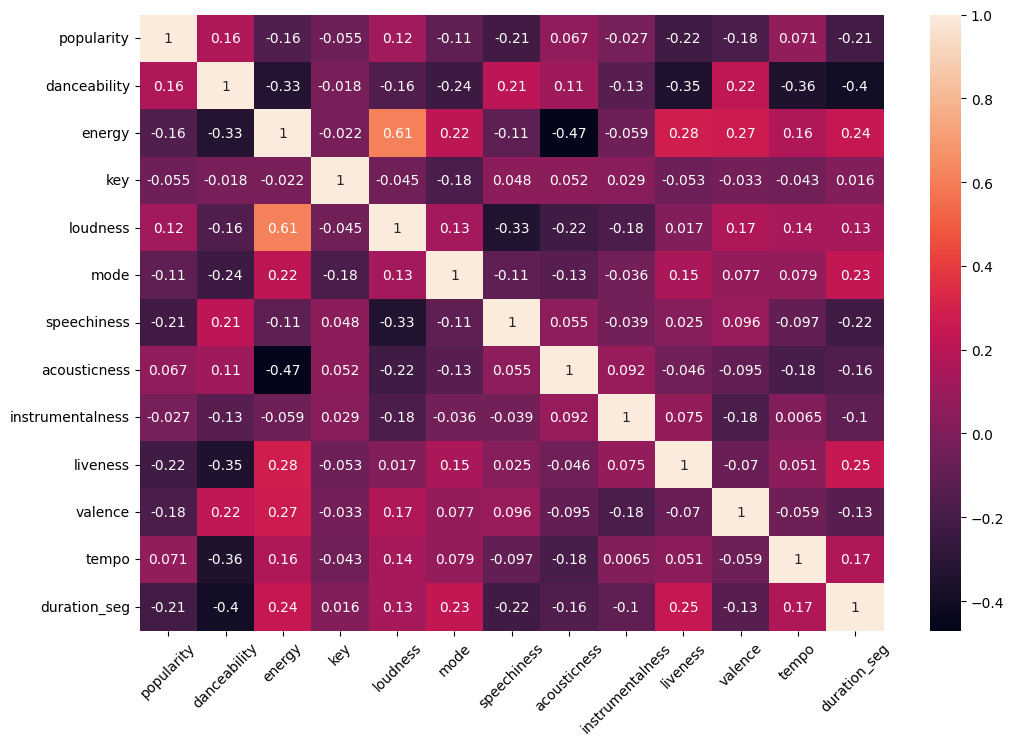

In [42]:
columna_a_eliminar = ['track_id','track_name','artist_name','genre']
df_heatmap = df_spotify.drop(columna_a_eliminar
                             ,axis=1)
correlation = df_heatmap.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.show()

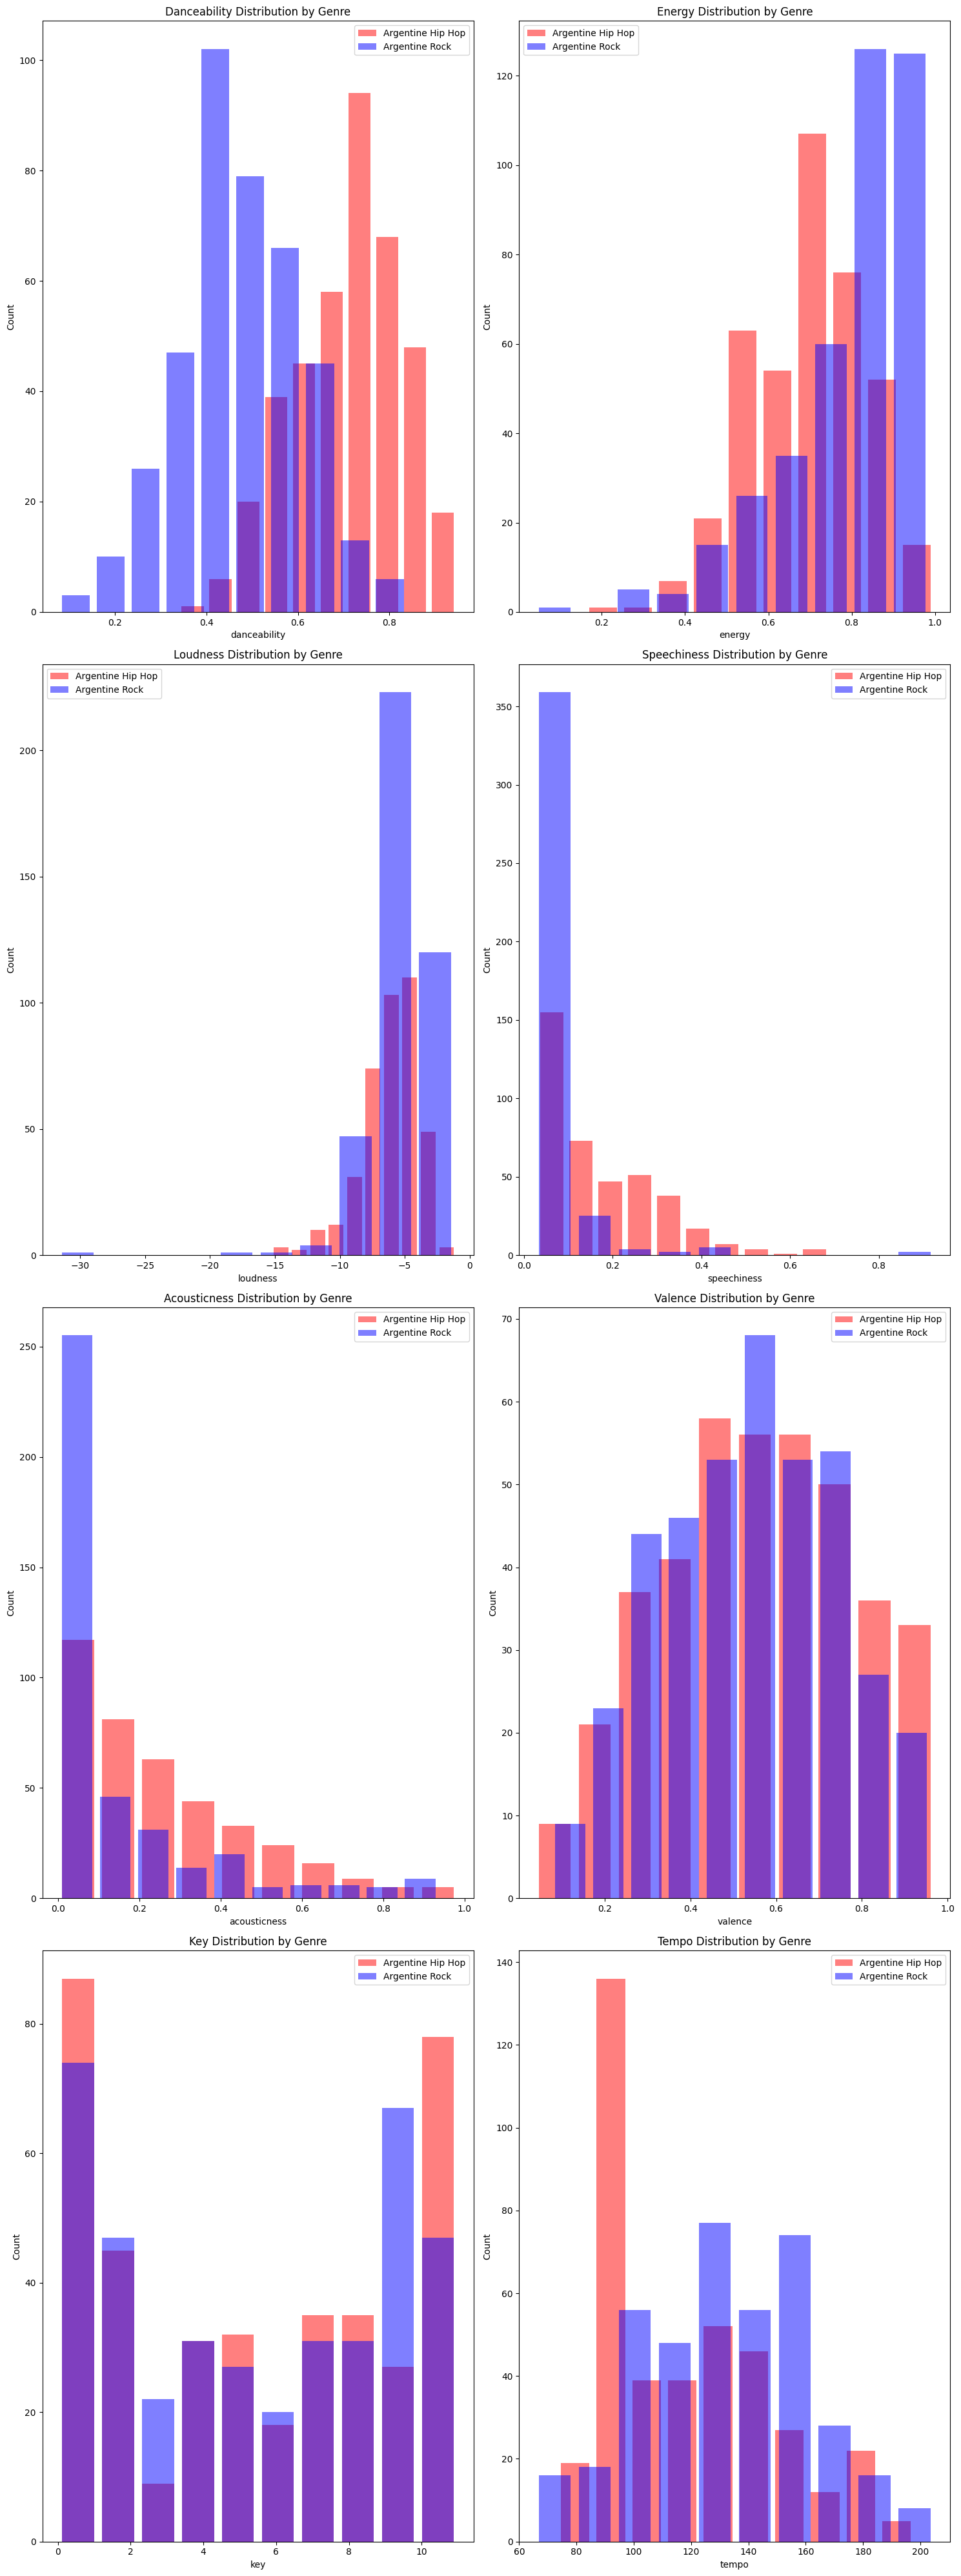

In [66]:
def plot_histogramas_por_feature(df, features, genre_colors=None):
    """
    Creates a set of histograms for various features of the songs in a DataFrame,
    filtering by each genre present in the DataFrame.

    Parameters:
        - df: Pandas DataFrame containing the songs data.
        - features: List of features (columns) for which the histograms will be created.
        - genre_colors: A dictionary that assigns colors to genres. If not provided,
          default colors will be used.

    Returns:
        - None
    """
    if genre_colors is None:
        genre_colors = {'0': 'blue', '1': 'red'}


    genres = {'0' : 'Argentine Rock', '1' : 'Argentine Hip Hop'}

    num_features = len(features)
    num_rows = (num_features + 1) // 2  
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 10*num_rows))  

    for idx, feature in enumerate(features):
        row_idx = idx // 2  
        col_idx = idx % 2   
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx] 

        # Iter by each genre into the DataFrame
        for genre in df['genre'].unique():
            # Filter by genre
            genre_data = df[df['genre'] == genre][feature]

            # Crearte the histogram of each genre
            ax.hist(genre_data, label=genres.get(str(genre),'¿?'), color=genre_colors.get(str(genre), 'gray'), alpha=0.5, rwidth=0.8)  # Ajustar rwidth para el ancho de las barras

        # Add labels, legend and title to subplot
        ax.legend()
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.set_title(f'{feature.capitalize()} Distribution by Genre')

    
    plt.tight_layout()
    plt.show()

features = ['danceability','energy','loudness','speechiness','acousticness', 'valence', 'key', 'tempo']  

plot_histogramas_por_feature(df_spotify, features)


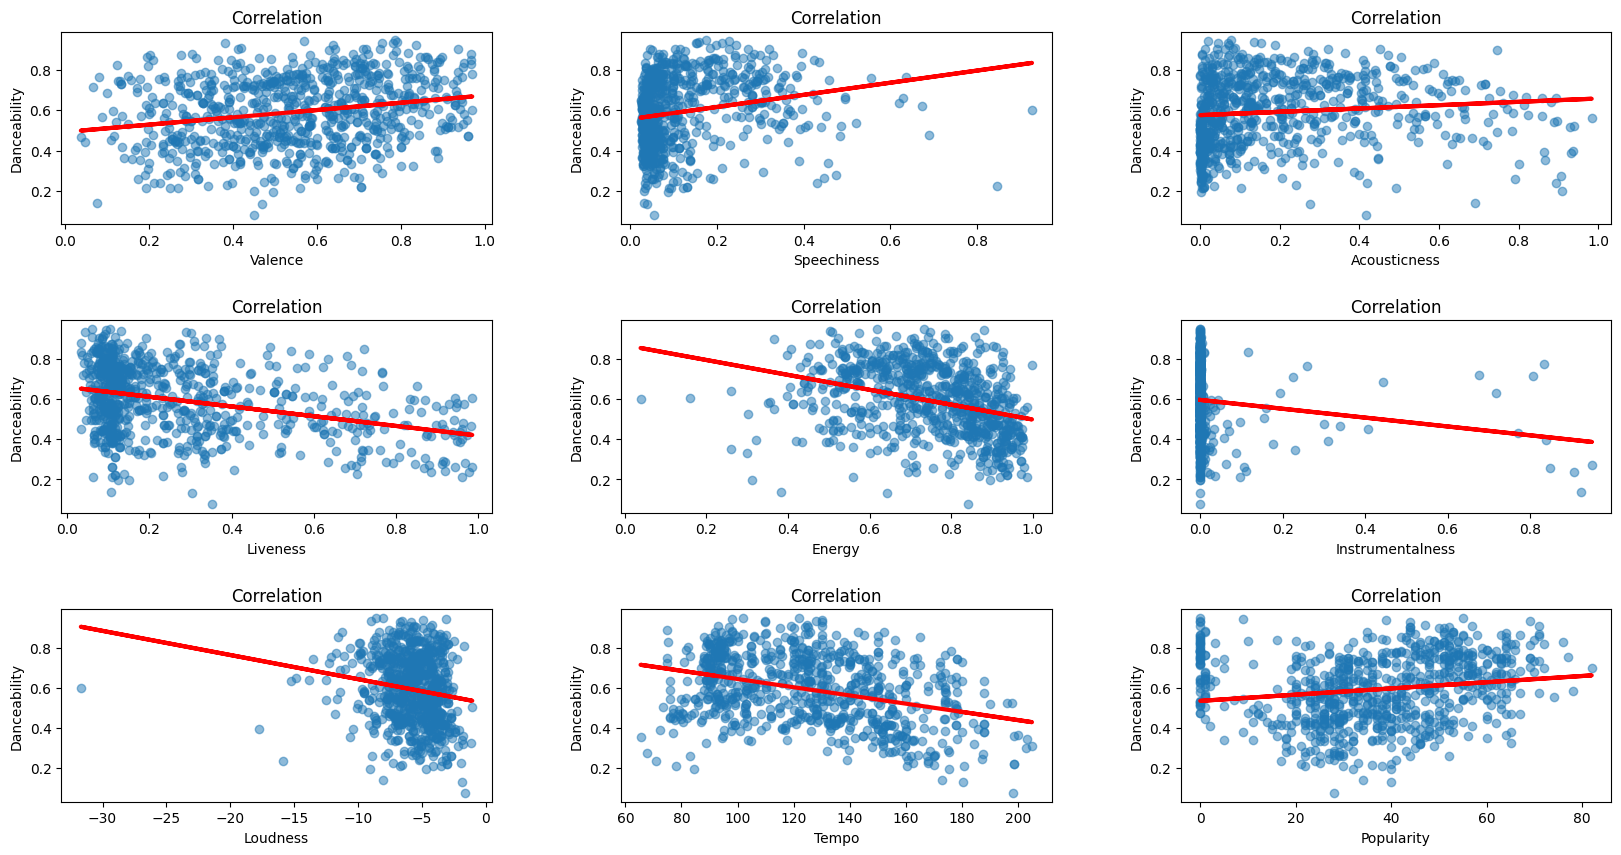

In [44]:
def plot_feature(ax, feature_name, X, y, x_label):
    regr = LinearRegression()
    regr.fit(X, y)

    ax.scatter(X, y, alpha=0.5, label=f'{feature_name} vs. Danceability')
    ax.plot(X, regr.predict(X), color="red", linewidth=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Danceability")
    ax.set_title("Correlation")

# Create a single figure for all the subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

# List of features and their corresponding column names
features = ["Valence", "Speechiness", "Acousticness", "Liveness", "Energy", "Instrumentalness", "Loudness", "Tempo","Popularity"]
columns = ["valence", "speechiness", "acousticness", "liveness", "energy", "instrumentalness", "loudness", "tempo","popularity"]

for i, feature_name in enumerate(features):
    row, col = divmod(i, 3)
    plot_feature(
        axes[row, col],
        feature_name,
        df_spotify[[columns[i]]].values,
        df_spotify["danceability"].values,
        feature_name
    )
plt.show()

# Logistic regression

In [45]:
def balanced_accuracy(cm): # "balanced accuracy" function
  sensitivity = cm[1,1]/(cm[1,1]+cm[0,1])
  specificity = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensitivity, specificity, (sensitivity + specificity)/2]

In [67]:
# Define the feature matrix X
fields = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg'] 
X = df_spotify[fields].values 
y = df_spotify['genre'] 
print(X.shape) 

scaler = MinMaxScaler() # maping of feature with MinMaxScaler. By default, this function map the values into [0,1]
scaler.fit(X) # maping paramiters
X = scaler.transform(X) 

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Init the model with 10000 iterations
regLog.fit(X, y) # Select the parameters to fit the model
score = regLog.score(X,y) # Get the score of this model

ypred = regLog.predict(X) # get the prediction of the model with the features
cm = confusion_matrix(ypred, y) # do the confusion matrix with ypred and true y
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Print the score of the model
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

(794, 12)
El score del modelo es de: 0.9421
Matriz de confusion del modelo es:
[[374  23]
 [ 23 374]]
Sensibilidad del modelo es de: 0.9421
Especificidad del modelo es de: 0.9421
BA del modelo es de: 0.9421


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_train[2],4)))
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_test[2],4)))

Para TRAIN set:
El score del modelo es de: 0.9369
Matriz de confusion del modelo es:
[[258  18]
 [ 17 262]]
Sensibilidad del modelo es de: 0.9357
Especificidad del modelo es de: 0.9382
BA del modelo es de: 0.9369


Para TEST set:
El score del modelo es de: 0.8787
Matriz de confusion del modelo es:
[[100   7]
 [ 22 110]]
Sensibilidad del modelo es de: 0.9402
Especificidad del modelo es de: 0.8197
BA del modelo es de: 0.8799


# Optimización de hiperparámetros

Vimos que al sumar regularización, la performance del modelo de repente se ve incrementada en el test set. Posiblemente esto dependa del valor de la constante de penalización C que usamos para la regresión. **Esto es lo que llamamos un hiperparámetro del modelo.** Otro hiperparámetro posible es el grado de la potencia máxima en la que aparecen los features.

Entonces tiene sentido hacer la siguiente pregunta: ¿para qué elección de hiperparámetros **maximizo** la performance del clasificador en el dataset de evaluación (test)?

Vamos a proponer la siguiente forma de abordar este problema:

1.   Generamos una función que entrene y evalue el clasificador usando un train-test split, que incorpore como input los hiperparámetros
2.   Para cada elección del par de hiperparámetros, repetimos este procedimiento unas cuantas (>100) veces y nos quedamos con la performance promedio. Esto es necesario porque el train-test split es aleatorio.
3.   Repetimos para todas las combinaciones de nuestros hiperparámetros y encontramos aquella que maximiza la performance del clasificador.

In [49]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  X_temp = X
  for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000)
  regLog.fit(X_train, y_train)

  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

In [51]:
# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['genre'] # Nuestra etiqueta sigue siende la misma de antes
print(X.shape) 


BA_train, BA_test = classifier(X,y,6,1)
print(BA_train, BA_test)

# aumento C

BA_train, BA_test = classifier(X,y,6,1000)
print(BA_train, BA_test)

# disminuyo C

BA_train, BA_test = classifier(X,y,6,0.0001)
print(BA_train, BA_test)

(794, 12)
0.9005351841241731 0.8513859275053305
0.9622697872561499 0.8651177460050463
0.7320138744543754 0.7035087719298245


In [52]:
n_values = np.arange(1,7) # rango de potencias maximas
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

[1, 0.2]
[1, 0.4]
[1, 0.6000000000000001]
[1, 0.8]
[1, 1.0]
[1, 1.2]
[1, 1.4000000000000001]
[1, 1.6]
[1, 1.8]
[1, 2.0]
[1, 2.2]
[1, 2.4000000000000004]
[1, 2.6000000000000005]
[1, 2.8000000000000003]
[1, 3.0000000000000004]
[1, 3.2]
[1, 3.4000000000000004]
[1, 3.6000000000000005]
[1, 3.8000000000000003]
[1, 4.0]
[1, 4.2]
[1, 4.4]
[1, 4.6000000000000005]
[1, 4.800000000000001]
[2, 0.2]
[2, 0.4]
[2, 0.6000000000000001]
[2, 0.8]
[2, 1.0]
[2, 1.2]
[2, 1.4000000000000001]
[2, 1.6]
[2, 1.8]
[2, 2.0]
[2, 2.2]
[2, 2.4000000000000004]
[2, 2.6000000000000005]
[2, 2.8000000000000003]
[2, 3.0000000000000004]
[2, 3.2]
[2, 3.4000000000000004]
[2, 3.6000000000000005]
[2, 3.8000000000000003]
[2, 4.0]
[2, 4.2]
[2, 4.4]
[2, 4.6000000000000005]
[2, 4.800000000000001]
[3, 0.2]
[3, 0.4]
[3, 0.6000000000000001]
[3, 0.8]
[3, 1.0]
[3, 1.2]
[3, 1.4000000000000001]
[3, 1.6]
[3, 1.8]
[3, 2.0]
[3, 2.2]
[3, 2.4000000000000004]
[3, 2.6000000000000005]
[3, 2.8000000000000003]
[3, 3.0000000000000004]
[3, 3.2]
[3, 3.

Por último, grafico como me quedan las BA para cada combinación de hiperparametros, y puedo encontrar cual es la BA máxima para cada caso, y con qué hiperparámetros la obtengo.

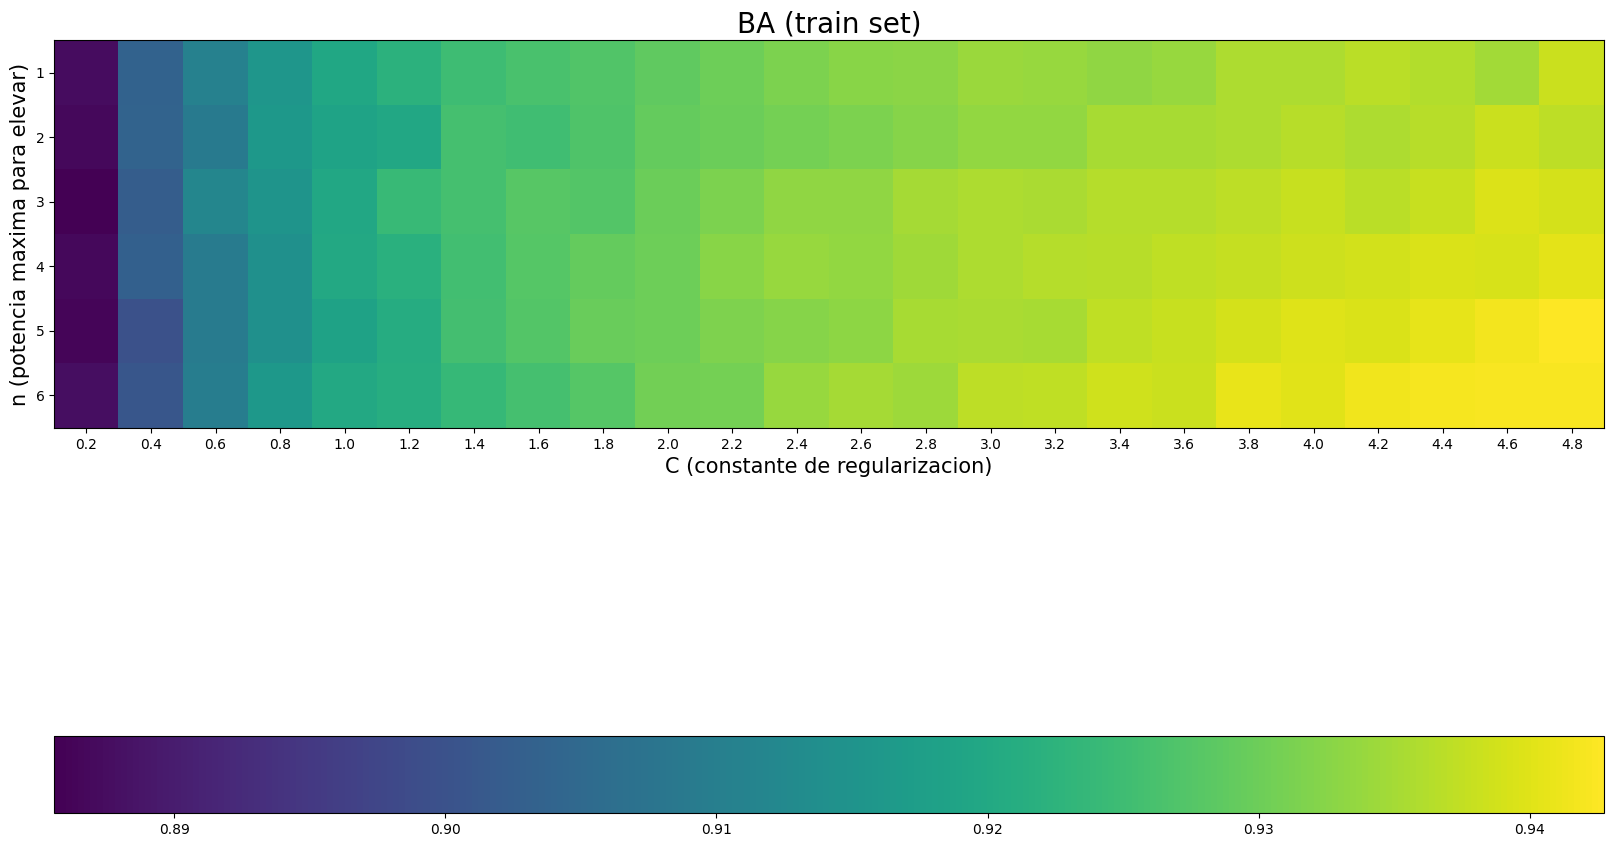

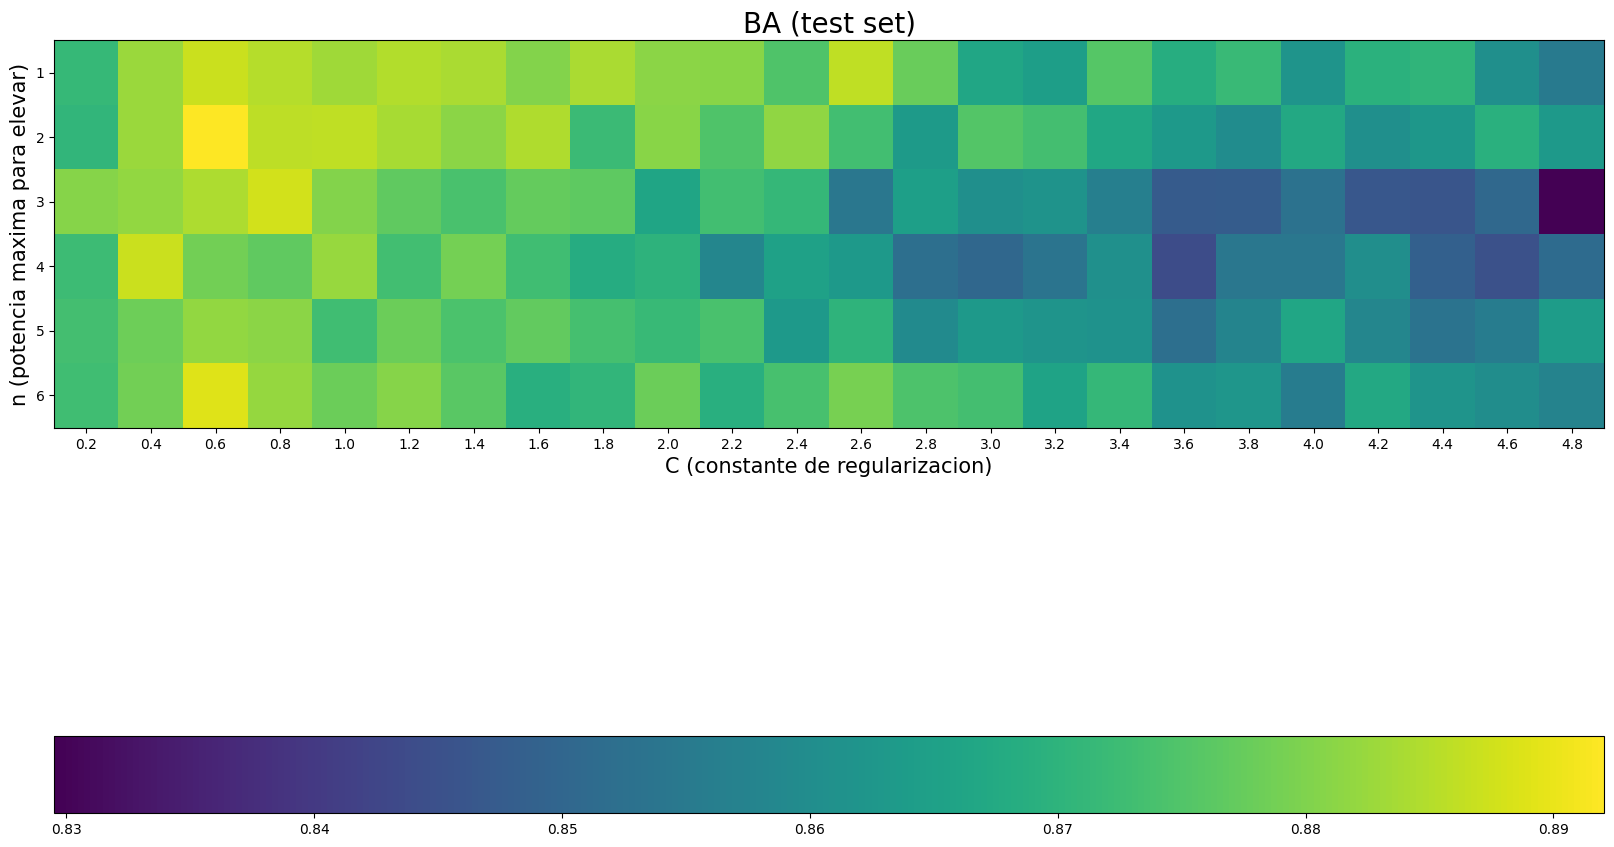

In [60]:
fig, ax = plt.subplots(1,1, figsize=(20,20))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = [round(value, 2) for value in c_values]
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(20,20)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = [round(value, 2) for value in c_values]
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)


In [61]:
BA_train, BA_test = classifier(X,y,2,0.6)
print(BA_train, BA_test)

0.9261865665806552 0.8893846373500857


# Modelo nulo y curva ROC

Supongamos que queremos construir un modelo que sepamos es incapaz de clasificar los datos por encima del nivel azar. Una forma de hacer esto es randomizando (shuffleando) las etiquetas. Si permutamos las etiquetas al azar, entonces rompemos la relación entre features y targets, y podemos asumir que no hay nada útil que el clasificador pueda aprender, de forma tal que el AUC de este modelo nos da una buena idea de lo que podemos obtener al nivel chance.

Veamos cómo se ve el ROC plot para datos con y sin randomización de labels.

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[0.9776898734177215, 0.9742088607594936, 0.984493670886076, 0.9837025316455696, 0.9588207018106073]
Estos es el promedio de todos los AUC:
0.9757831277038935


Y ahora voy a todo pero permutando aleatoriamente todos los targets antes de empezar.

In [73]:
y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)



print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[0.59375, 0.4710443037974683, 0.565110759493671, 0.5113924050632912, 0.5013619612241629]
Estos es el promedio de todos los AUC:
0.5285318859157186


C:\Users\bruno\AppData\Local\Temp\ipykernel_18872\3815737450.py:2: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle(y_shuffled) # shuffleo


Ahora vamos a plotear las dos curvas ROC juntas para ver como se ven:

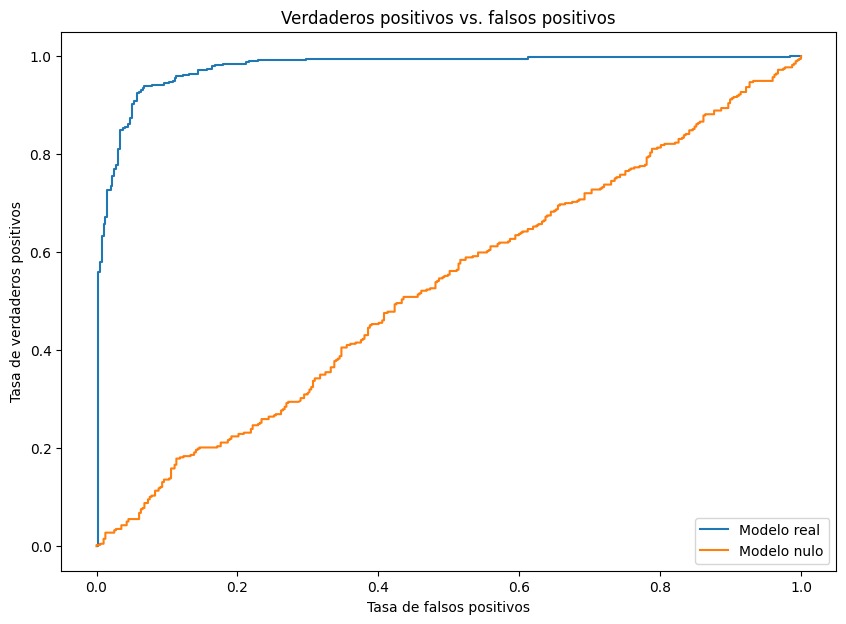

In [74]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

# Clustering 

 

In [13]:
# importamos las librerías usuales de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    # K-means
from sklearn.cluster import AgglomerativeClustering   # Clustering jerárquico

# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador


In [30]:
df_spotify.head()

,track_id,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seg,genre
0,3dD1H5ick5Txfngx7hje7X,HOOP HOOP,Trueno,51,0.482,0.894,D,-3.595,menor,0.1100,0.400,0.0,0.7290,0.392,91.303,157.325,argentine hip hop
1,1iEv1uCSDTN7YotFX4iHB9,FUCK EL POLICE,Trueno,54,0.594,0.786,A#,-4.327,mayor,0.3690,0.313,0.0,0.1000,0.113,90.837,157.554,argentine hip hop
2,3lkiTKxSDxOqZkQnf9FUEo,ARGENTINA,Trueno,58,0.575,0.670,E,-5.656,mayor,0.3750,0.824,0.0,0.2510,0.362,174.211,233.214,argentine hip hop
3,73zQG7t3tZDyePEflVSqJJ,TIERRA ZANTA,Trueno,59,0.565,0.807,C#,-5.413,mayor,0.2740,0.547,0.0,0.4210,0.310,104.777,237.658,argentine hip hop
4,6egwHn0qyQH7HCFu4APhmk,UN PASO,Trueno,0,0.778,0.853,D,-3.455,menor,0.0748,0.249,0.0,0.0932,0.533,92.959,192.143,argentine hip hop


In [43]:
# Creación del modelo de PCA con 100 componentes
pca = PCA(n_components = 10)
#Vamos a determinar las columnas que tengan algun peso significativo para este modelo
columna_a_eliminar = ['track_id','track_name','artist_name','genre','popularity','key','mode']
df_gener,targets = df_spotify.drop(columna_a_eliminar
                             ,axis=1),df_spotify['genre']
# Ajuste y transformación de los datos
pca.fit(df_gener)
X_pca = pca.transform(df_gener)
X_pca.shape

(158, 10)

Ploteamos el dataset en el espacio de las primeras dos componentes principales

Text(0, 0.5, 'Segunda componente principal')

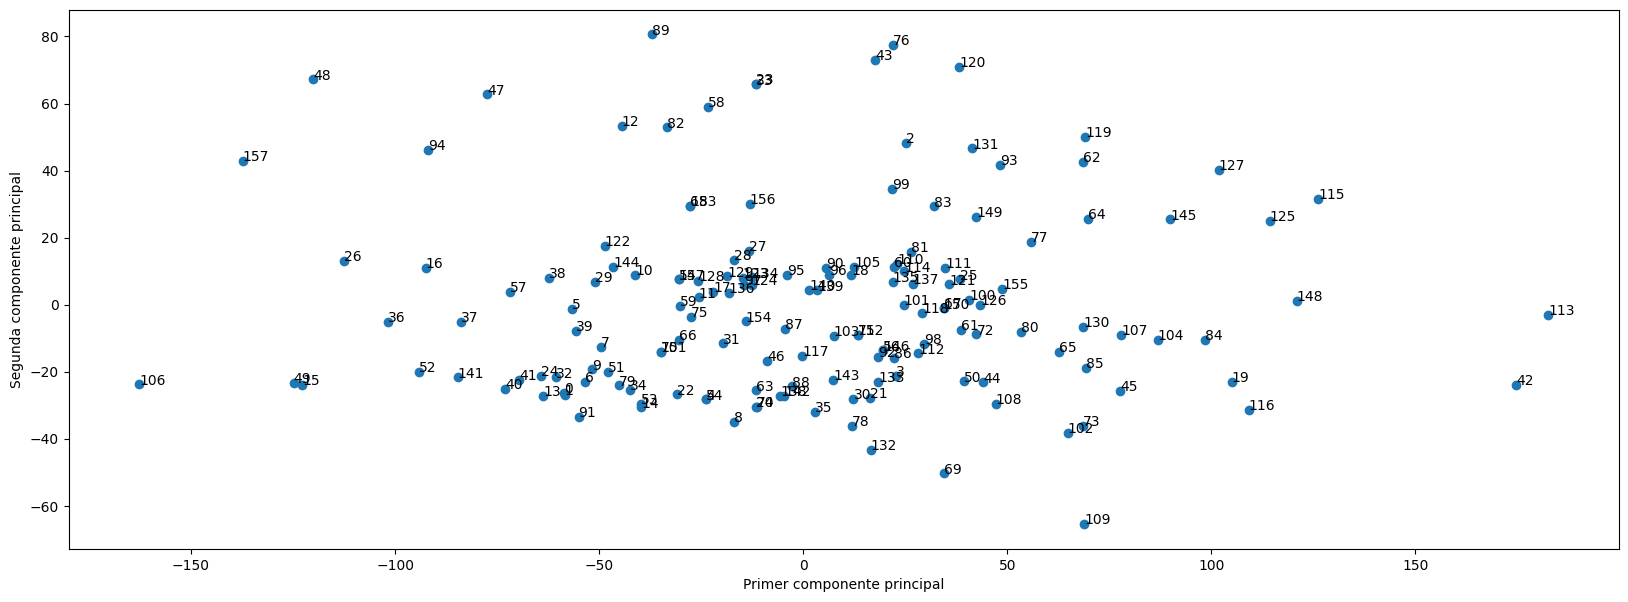

In [34]:
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Por cada dato escribimos a qué instancia corresponde
for i in range(df_gener.shape[0]):
  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Ahora sí aplicamos el método de clusterización K-Means para agrupar las fotos en base a sus componentes principales. Como sabemos que el dataset consta de 2 generos diferentes utilizamos esta información para pedirle al algoritmo que encuentre k=2 clusters con la esperanza que podamos agrupar las cansiones en ellos.

In [35]:
# Creación del modelo KMeans con k = 40
kmeans = KMeans(n_clusters=2)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

KMeans(n_clusters=2)

Para acceder a las etiquetas que le asignó el modelo a cada sample usamos 'kmeans.labels_'

In [36]:
# Nos fijamos las etiquetas asignadas a las primeras 10 muestras y los counts que recibió cada una
np.unique(kmeans.labels_[:10], return_counts=True)

(array([0, 1]), array([2, 8], dtype=int64))

Veamos qué es lo que está pasando. Vamos a plotear el dataset en el espacio de las primeras dos componentes principales pero además vamos a asignarle un color a cada sample que corresponde a la etiqueta asignada por el modelo. También vamos a graficar con una "X" el centroid de cada cluster.

In [37]:
# Guardo las posiciones de los centroids
centroids = kmeans.cluster_centers_

# Printeo las dimensiones de las posiciones
print("Shape de los centroids:",centroids.shape)
# Printeo las posiciones de las primeras 5 muestras en sus primeras dos componentes principales
print(centroids[:5,[0,1]])

Shape de los centroids: (2, 10)
[[ 45.52391024   0.40876601]
 [-44.38581248  -0.39854685]]


Text(0, 0.5, 'Segunda componente principal')

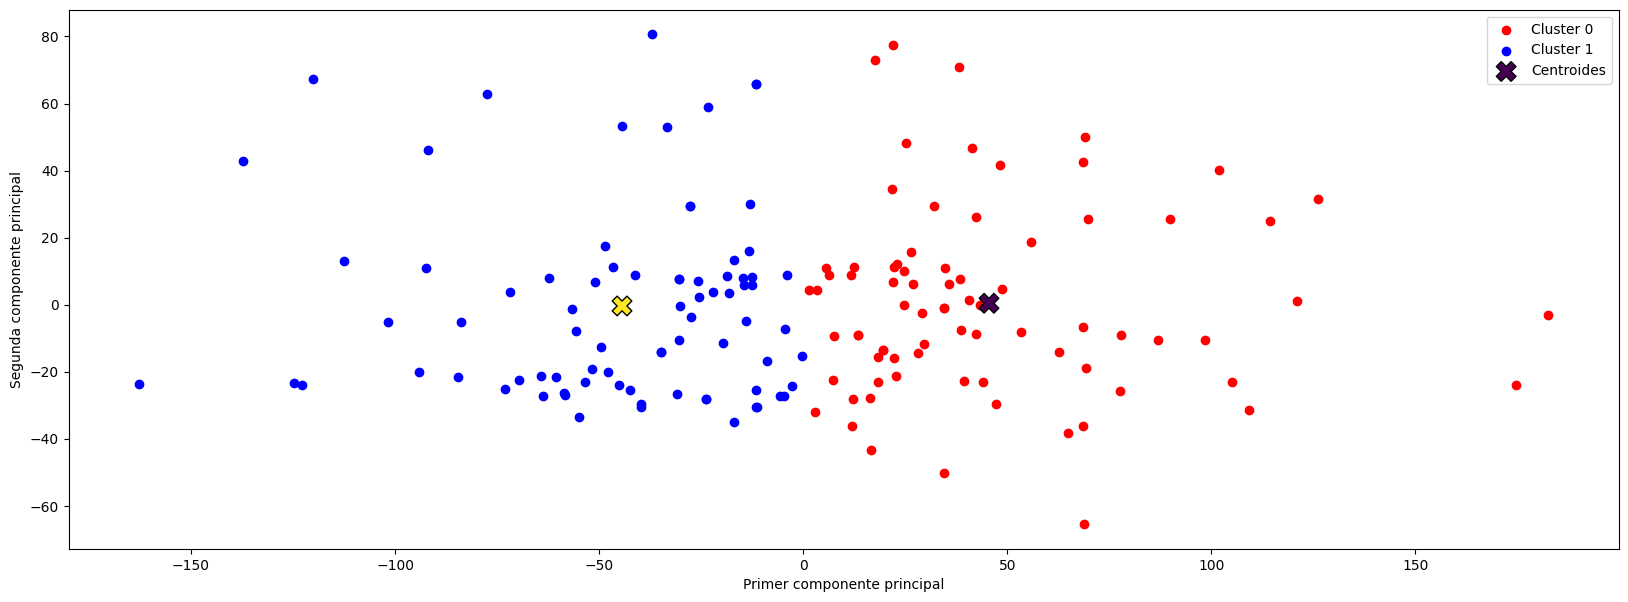

In [38]:
# Este bloque es similar al anterior pero agregando color a cada muestra en el scatter plot según la etiqueta asignada

fig, ax = plt.subplots(figsize=(20, 7))

# Crear un diccionario de colores para asignar colores específicos a cada etiqueta
colors = {0: 'red', 1: 'blue'}

# Hacer un scatter plot de cada uno de los datos con colores específicos para cada etiqueta
for label in np.unique(kmeans.labels_):
    ax.scatter(X_pca[kmeans.labels_ == label, 0], X_pca[kmeans.labels_ == label, 1],
               c=colors[label], label=f'Cluster {label}')

# Hacer un scatter plot de los centroides con el mismo color que las etiquetas
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black', label='Centroides')

# Agregar la leyenda
ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')


In [39]:
# Mostrar el resultado final
# labels = kmeans.labels_
# Suponiendo que ya tienes un DataFrame df y las etiquetas de cluster kmeans.labels_

# Agregar una columna al DataFrame con las etiquetas de cluster
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets

df_gener.head(50)

# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)


cluster             0   1
genre                    
argentine hip hop  13  42
argentine rock     65  38


#### 1 [Método del codo](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)

Se hace un grafico de la función objetivo en función de la elección de k y se elige el k correspondiente al punto donde agregar un cluster más no baja significativamente el valor que queremos minimzar. Esto se puede detectar a ojo o utilizando algún paquete de python como ['kneed'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf)

In [40]:
from kneed import KneeLocator # importamos el paquete para detectar el codo

In [44]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 40):
  print(k)
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(df_gener)
  sse.append(kkmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Vamos a graficar SEE en función del número de clusters k

Text(0, 0.5, 'SSE')

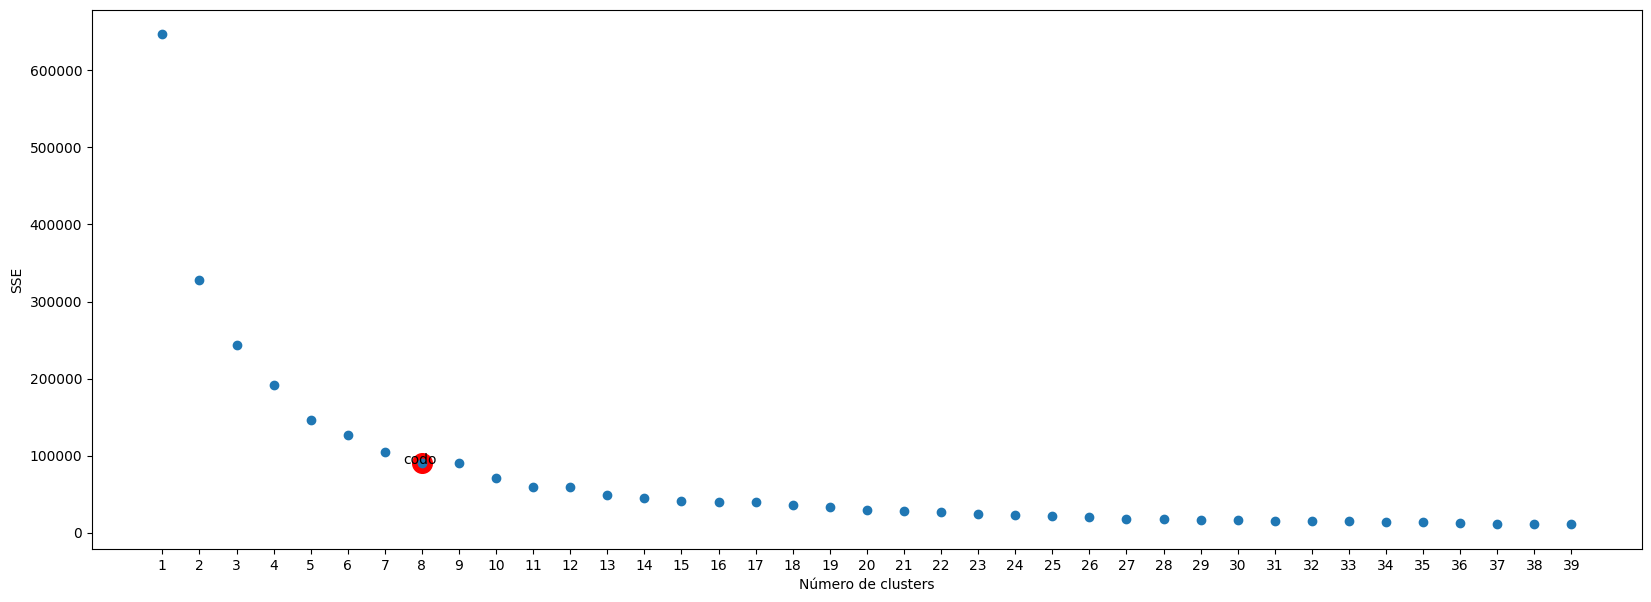

In [45]:
fig, ax = plt.subplots(figsize = (20, 7))

# esta dos lineas las agrego para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(8, sse[7], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(7.5, sse[7]-1000, s="codo")       # agregamos un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SSEvsK
ax.scatter(range(1, 40), sse)
ax.set_xticks(range(1, 40))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("SSE")

In [46]:
kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

El codo está en k = 7


Veamos entonces cómo se ve el modelo con k=9 para el dataset

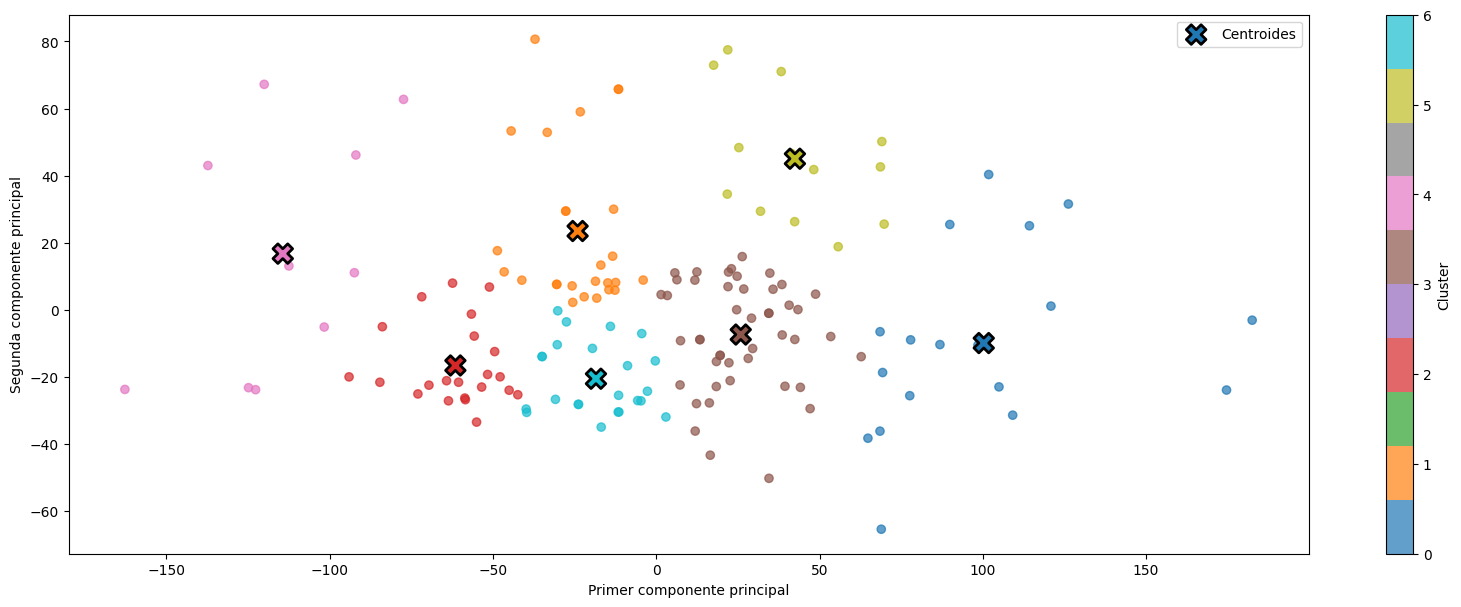

In [47]:
# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()


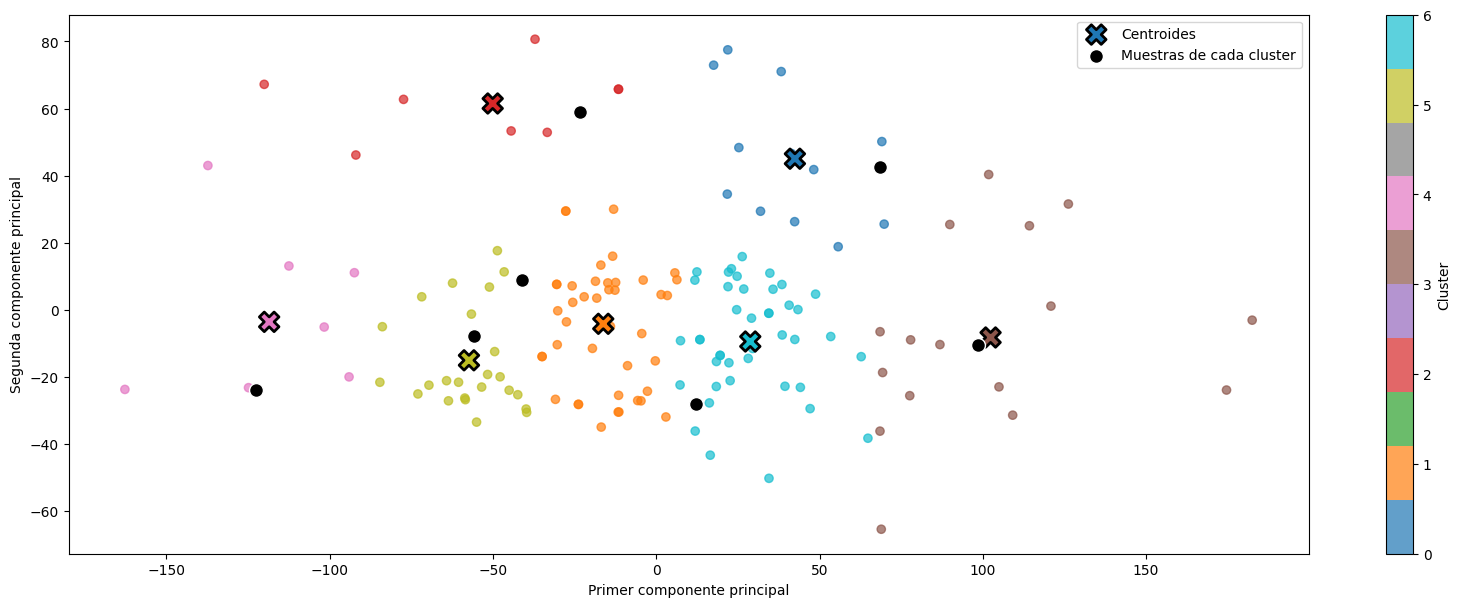

Muestras de cada cluster:
Cluster 0: [ 6.86640592e+01  4.25885669e+01  9.44037351e-01 -1.41314475e-01
  9.62474969e-02  7.60976092e-02 -7.43142755e-02 -7.35206606e-03
 -1.09746687e-02 -3.72734280e-02]
Cluster 1: [-41.16361454   8.78826049   1.67873286   0.07588895   0.14081144
  -0.15436917  -0.24786039  -0.05394868   0.12336691  -0.07245281]
Cluster 2: [-2.32571704e+01  5.90166975e+01  2.31434457e+00 -3.00993349e-01
 -2.12449956e-01 -1.85147691e-01  7.65378075e-02  1.03413133e-01
 -8.69682176e-02 -6.10815217e-03]
Cluster 3: [ 9.85188525e+01 -1.05898062e+01 -1.70408873e-01 -9.95841058e-02
 -1.16291415e-01  2.22496922e-01  3.50403670e-02 -2.57019134e-02
  6.45584296e-02 -1.04299828e-02]
Cluster 4: [-1.22713201e+02 -2.38737658e+01  2.36130725e+00 -1.53090520e-01
  5.67659675e-01  4.30618788e-01 -2.71236124e-01 -5.31991308e-04
 -1.29570850e-01  1.72458664e-01]
Cluster 5: [-5.57425986e+01 -7.88865329e+00 -1.46662847e+00  2.72146040e-01
 -2.55589131e-01  1.74614232e-02 -3.29733713e-02 -6.51

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supongo que X_pca ya está definido y contiene los datos reducidos en componentes principales

# Creación del modelo KMeans con k = 8
kmeans9 = KMeans(n_clusters=7)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans9.fit(X_pca)

# Guardamos la posición de los centroids
centroids9 = kmeans9.cluster_centers_

# Crear una lista para almacenar una muestra de cada cluster
samples_per_cluster = []

# Iterar sobre cada cluster y seleccionar una muestra
for cluster_id in range(kmeans9.n_clusters):
    # Obtener los índices de los datos que pertenecen al cluster actual
    indices = np.where(kmeans9.labels_ == cluster_id)[0]
    
    # Seleccionar una muestra al azar de los índices del cluster actual
    if len(indices) > 0:
        sample_index = np.random.choice(indices, size=1)[0]
        samples_per_cluster.append(X_pca[sample_index])
    else:
        # Si no hay elementos en este cluster, añadir un valor nulo o manejar de otra forma
        samples_per_cluster.append(None)

# Convertir la lista a un array de numpy para facilidad de manipulación (si todos los clusters tienen muestras)
samples_per_cluster = np.array(samples_per_cluster)

# Plot
fig, ax = plt.subplots(figsize=(20, 7))

# Hacemos un scatter plot de cada uno de los datos con colores más llamativos
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans9.labels_, cmap='tab10', alpha=0.7)

# Hacemos un scatter plot de los centroids con colores más llamativos
ax.scatter(centroids9[:, 0], centroids9[:, 1], marker="X", s=200, linewidths=2,
           c=np.unique(kmeans9.labels_), cmap='tab10', edgecolors='black', label='Centroides')

# Hacemos un scatter plot de las muestras de cada cluster
samples_per_cluster = np.array(samples_per_cluster)
ax.scatter(samples_per_cluster[:, 0], samples_per_cluster[:, 1], marker="o", s=100, 
           c='black', edgecolors='white', label='Muestras de cada cluster')

# Agregar la barra de color para indicar la asignación de clusters
plt.colorbar(scatter, ax=ax, label='Cluster')

ax.legend()

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

plt.show()

# Mostrar las muestras seleccionadas
print("Muestras de cada cluster:")
for i, sample in enumerate(samples_per_cluster):
    print(f"Cluster {i}: {sample}")

In [51]:
df_confusion = df_gener
df_confusion['cluster'] = kmeans.labels_
df_confusion['genre'] = targets


# Calcular la matriz de confusión
confusion_matrix = pd.crosstab(df_confusion['genre'], df_confusion['cluster'])

print(confusion_matrix)

cluster             0   1
genre                    
argentine hip hop  13  42
argentine rock     65  38


In [28]:
#Dicctionary key to notes
keyToNotes = {0 : 'C',
              1 : 'C#',
              2 : 'D',
              3 : 'D#',
              4 : 'E',
              5 : 'F',
              6 : 'F#',
              7 : 'G',
              8 : 'G#',
              9 : 'A',
              10 : 'A#',
              11 : 'B',
              -1 : '?'}
mapeoModo = {0 : 'mayor',
             1 : 'menor'}
df_spotify['key'] = df_spotify['key'].replace(keyToNotes)
df_spotify['mode'] = df_spotify['mode'].replace(mapeoModo)
df_spotify.head()


,track_id,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_seg,genre
0,3dD1H5ick5Txfngx7hje7X,HOOP HOOP,Trueno,51,0.482,0.894,D,-3.595,menor,0.1100,0.400,0.0,0.7290,0.392,91.303,157.325,argentine hip hop
1,1iEv1uCSDTN7YotFX4iHB9,FUCK EL POLICE,Trueno,54,0.594,0.786,A#,-4.327,mayor,0.3690,0.313,0.0,0.1000,0.113,90.837,157.554,argentine hip hop
2,3lkiTKxSDxOqZkQnf9FUEo,ARGENTINA,Trueno,58,0.575,0.670,E,-5.656,mayor,0.3750,0.824,0.0,0.2510,0.362,174.211,233.214,argentine hip hop
3,73zQG7t3tZDyePEflVSqJJ,TIERRA ZANTA,Trueno,59,0.565,0.807,C#,-5.413,mayor,0.2740,0.547,0.0,0.4210,0.310,104.777,237.658,argentine hip hop
4,6egwHn0qyQH7HCFu4APhmk,UN PASO,Trueno,0,0.778,0.853,D,-3.455,menor,0.0748,0.249,0.0,0.0932,0.533,92.959,192.143,argentine hip hop


In [29]:
irresponsables = df_spotify.loc[~df_spotify["artist_name"].isin(artist_names)]
print(irresponsables)

Empty DataFrame
Columns: [track_id, track_name, artist_name, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_seg, genre]
Index: []
